In [1]:
#!pip install ttpy
#!pip install git+https://github.com/oseledets/ttpy.git@refs/pull/87/head
# As soon as #87 is merged you can drop @... suffix and run.
!pip install git+https://github.com/oseledets/ttpy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oseledets/ttpy.git to /tmp/pip-req-build-wa1pxskv
  Running command git clone --filter=blob:none --quiet https://github.com/oseledets/ttpy.git /tmp/pip-req-build-wa1pxskv
  Resolved https://github.com/oseledets/ttpy.git to commit a50d5e0ce2a033a4b1aa703715cb85d715b9b34a
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ttpy: filename=ttpy-1.2.0-cp310-cp310-linux_x86_64.whl size=3545947 sha256=9b78a77b71aeb5735d3b9836126207f99a34e4fce2fceb481ab5e5f0a53de2d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-01kfoskz/wheels/0f/9c/16/16342a640cb36d2dad60b14dea6a8e40d25a21802581aee13c
Successfully built ttpy


In [5]:
import numpy as np
from numpy import zeros,reshape,sqrt,arange,vectorize,extract,int,empty_like
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import mpmath
from mpmath import mp,mpf,floor,exp,nint
import tt

# Code to support deprecated numpy commands in TT-Toolbox
np.object=object
np.int=int
np.complex=complex
np.float=float
np.bool=bool

## Global Optimization of Molecular Structures

Micheline B. Soley, Paul Bergold, and Victor S. Batista

[J. Chem. Theory Comput. **17**: 3280-3291(2021)](http://ursula.chem.yale.edu/~batista/publications/IPA.pdf)

Given a loss function $V(x)$ and an initial distribution $\rho_0(x)$ for parameter $x$, update the distribution $n$ times, as follows:
\begin{equation}
\rho_{k+1}(x) = \frac{e^{-V(x)} \rho_k(x)}{\|e^{-V(x)} \rho_k(x) \|}
\end{equation}
with $k=0,1,2\cdots,n-1$ until the distribution has significant amplitude only at the global minimum of $V(x)$. Resolve the value of $x$ at the global minimum $x_m$ by computing the expectation value based on $\rho_n(x)$, as follows:
\begin{equation}
x_m = \int dx~x~\rho_n(x).
\end{equation}

 \begin{equation}
V(x) = \sum_{k=0}^{D-1} \sum_{j=1}^4 c_j x_k^j,
\end{equation}
with $c_1=0.429$, $c_2=1.126$, $c_3=0.143$ and $c_4=0.563$.

Screen Shot 2021-07-31 at 1.29.18 PM.png

Above: DNA chain (left) of D = 50 hydrogen bonds corresponding to 25 hydrogen-bonded adenine−thymine base pairs (inset, top right), with hydrogen bonds shown as dashed yellow lines. Each hydrogen bonded proton attaches to either base, with energy represented by the
double-well potential (bottom right).

j=,Vm= 0 3.151123046874995
j=,Vm= 1 0.10040884120595497
j=,Vm= 2 0.0500920703093759
j=,Vm= 3 0.033400199674142685
j=,Vm= 4 0.025055996857744643
j=,Vm= 5 0.020033466005929382
j=,Vm= 6 0.016682409886344694
j=,Vm= 7 0.014289885645791617
j=,Vm= 8 0.01249767150794731
j=,Vm= 9 0.011105898935983214
j=,Vm= 10 0.00999375414478873
j=,Vm= 11 0.009084231120536052
j=,Vm= 12 0.008326231910859232
j=,Vm= 13 0.007684606400208639
j=,Vm= 14 0.007134374253272386
j=,Vm= 15 0.006657271596813169
j=,Vm= 16 0.006239618875605474
j=,Vm= 17 0.005870958582533027
j=,Vm= 18 0.005543155991444389
j=,Vm= 19 0.005249787647882401
j=,Vm= 20 0.004985714305958136
j=,Vm= 21 0.004746775552495965
j=,Vm= 22 0.0045295670005360365
j=,Vm= 23 0.004331275039305763
j=,Vm= 24 0.0041495526825457586
j=,Vm= 25 0.003982425328405582
j=,Vm= 26 0.0038282185834906056
j=,Vm= 27 0.0036855025035750708
j=,Vm= 28 0.003553048118573502
j=,Vm= 29 0.003429793196085012


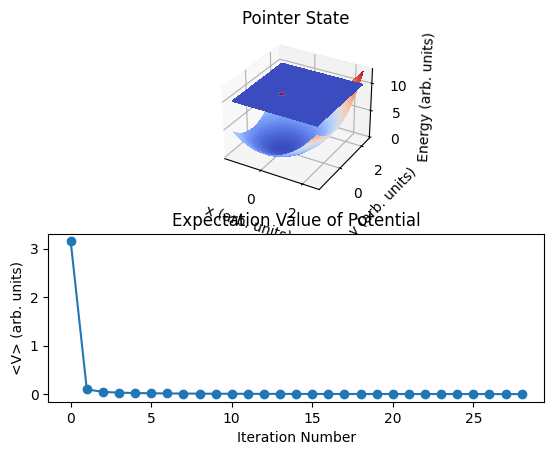

j=,k=,xm=,Vm= 29 0 -2.4417203508067887e-05 0.003429793196085012
j=,k=,xm=,Vm= 29 1 -2.4417203508067887e-05 0.003429793196085012


In [9]:
beta=10 #how quickly each sifting step happens, bigger means more "severe"
dim=2
eps=1.0e-14 #accurate of tensor
rma=3  #soft max rank
nsteps=30
d=8     #this and below defines devisions in position space
npts=2**d
xmin=-1.5
xmax=2.5
dx=(xmax-xmin)/npts

def gen_1d(mat,e,i,d):
  #x vs y positions, a bit weird
    w=mat
    for j in range(i):
        w=tt.kron(e,w)
    for j in range(d-i-1):
        w=tt.kron(w,e)
    return w

def rhoo(input):
  #initially uniform everywhere
    out=1.+0.*np.sum(input,axis=1)
    return(out);

def V(input):
    out=np.sum(input**2,axis=1)
    return(out);

def plot_f2d(x,rho,V,t,vm):
    fig=plt.figure()
    yy,xx=np.meshgrid(x, x)
    ax=fig.add_subplot(211, projection='3d')
    ax.plot_surface(xx,yy,rho+10,cmap=cm.coolwarm,antialiased=False)
    ax.plot_surface(xx,yy,V,cmap=cm.coolwarm,antialiased=False)
    ax.set_xlabel("x (arb. units)")
    ax.set_ylabel("y (arb. units)")
    ax.set_zlabel("Energy (arb. units)")
    ax.set_title("Pointer State")
    ax1=plt.subplot(212)
    plt.plot(t[:j],vm[:j],'o-')
    plt.xlabel("Iteration Number")
    plt.ylabel("<V> (arb. units)")
    ax1.set_title("Expectation Value of Potential")
    plt.show()

def plot_f(t,vm):
    fig = plt.figure()
    plt.plot(t[:j],vm[:j],'o-')
    plt.yscale('log')
    plt.xlabel("Iteration Number")
    plt.ylabel("<V> (arb. units.")
    plt.title("Expectation Value of Potential")
    plt.show()

if __name__ == "__main__":
    x=np.arange(xmin, xmax, dx)
    t=np.arange(0,nsteps,1)
    xm=np.zeros((nsteps,dim))
    vm=np.zeros(nsteps)
    ttone=tt.ones(2, d)
    xx=np.reshape(x, [2]*d)
    xx=tt.tensor(xx,eps)
    ttoned=ttone
    for ii in range(dim-1):
      ttoned=tt.kron(ttone,ttoned)
    txx=[gen_1d(xx,ttone,i,dim) for i in range(dim)]
    ttrho=tt.multifuncrs2(txx, rhoo, eps,verb=0,rmax=rma)
    norm=tt.dot(ttrho,ttoned)
    ttrho=ttrho*(1.0/norm)

    ttVV=tt.multifuncrs(txx,V,eps,verb=0,rmax=rma)

    for j in range(nsteps):
        vm[j]=tt.dot(ttrho,ttVV)
        for k in range(dim):
            xm[j,k]=tt.dot(ttrho,txx[k])
        print("j=,Vm=",j,vm[j])
        if j == nsteps-1:
            if dim == 2:
                ttrhor=np.reshape(ttrho.full(),[2**d]*dim)
                ttVVr =np.reshape(ttVV.full(),[2**d]*dim)
                plot_f2d(x,ttrhor,ttVVr,t,vm)
            else:
                plot_f(t,vm)
        tto = lambda r:np.exp(-beta*V(r))
        ttoracle=tt.multifuncrs2(txx,tto,eps,verb=0,rmax=rma)
        ttrho=ttrho*ttoracle
        ttrho=ttrho.round(eps,rma)
        norm=tt.dot(ttrho,ttoned)
        ttrho=ttrho*(1.0/norm)

    for k in range(dim):
        print("j=,k=,xm=,Vm=",j,k,xm[j,k],vm[j])


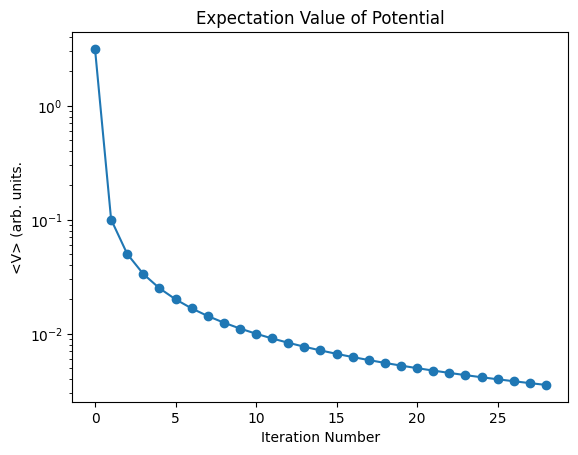

In [10]:
plot_f(t,vm)

## Biprime Factorization

In [20]:
def parameters():
    global dim,eps,num,rmax,nsteps,d,searchspacesize,beta
    num=mpf(100003*100019)
    sqrtnum=sqrt(num)
    if sqrtnum < 24:
        d=3
    elif sqrtnum < 60:
        d=4
    elif sqrtnum < 138:
        d=5
    elif sqrtnum < 314:
        d=6
    elif sqrtnum < 728:
        d=7
    elif sqrtnum < 1622:
        d=8
    elif sqrtnum  < 3674:
        d=9
    elif sqrtnum < 8168:
        d=10
    elif sqrtnum < 17882:
        d=11
    elif sqrtnum < 38892:
        d=12
    elif sqrtnum < 84048:
        d=13
    elif sqrtnum < 180512:
        d=14
    else:
        print("Error: Dimension not implemented.")
        quit()
    rmax=100
    beta=20
    dim=1
    eps=1.0e-100
    nsteps=1
    searchspacesize=2**d
    return()

def rhoo(input):
    V=1.0+0*input
    return V

def is_prime(n):
    if n % 2 == 0 and n > 1:
        return False
    return all(n % i for i in range(3,int(sqrt(n))+1,2))

def tto(input, param=None):
    global num,beta
    nevals,dim=input.shape
    out=np.zeros((nevals,))
    for ii in range(nevals):
        a=num-nint(input[ii,0])*floor(num/nint(input[ii,0]))
        if a > 10:
          a=10
        out[ii]=input[ii,1]*exp(-beta*a)
    return(out)

if __name__ == "__main__":
    global eps,num,rmax,nsteps,d,searchspacesize,ttavg
    np.random.seed(1234)
    mp.dps=2000
    parameters()
    print(num)
    a=arange(2, 10**6)
    foo=vectorize(is_prime)
    pbools=foo(a)
    primes=extract(pbools, a)
    pp=np.zeros(searchspacesize,dtype=float)
    for j in range(searchspacesize):
        pp[j]=primes[j]
    ttpp=tt.tensor(reshape(pp,[2]*d))
    lprimes=[]
    ttrho=tt.multifuncrs2([ttpp],rhoo,eps,verb=0,rmax=rmax)
    for k in range(nsteps):
        ttrho=tt.multifuncrs([ttpp,ttrho],tto,eps,verb=0,rmax=rmax)
        ttrho=ttrho*(1.0/(ttrho.norm())**2)
    ttrhostore=ttrho
    ttavg=nint(tt.dot(ttpp,ttrho))
    heaviside=empty_like(pp)
    for j in range(searchspacesize):
        if pp[j]-0.5 > ttavg:
            heaviside[j]=0.
        else:
            heaviside[j]=1.
    ttheaviside=tt.tensor(reshape(heaviside,[2]*d))
    ttrho=ttheaviside*ttrhostore
    ev=nint(tt.dot(ttpp,ttrho*(1.0/(ttrho.norm()))))
    num=nint(num/ev)
    lprimes.append(ev)
    lprimes.append(num)
    print("prime factors=",lprimes,num)


10002200057.0
prime factors= [mpf('100003.0'), mpf('100019.0')] 100019.0


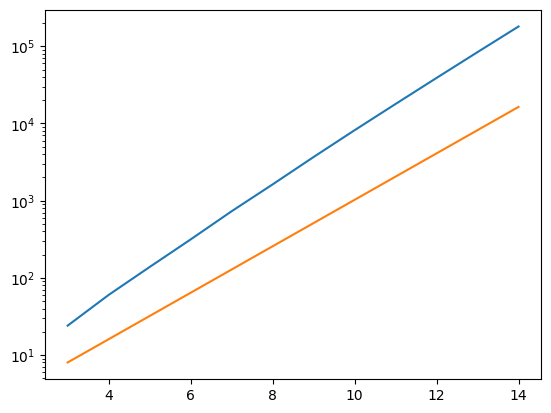

In [16]:
dim_x = np.arange(3,15)
a = [24,60,138,314,728,1622,3674,8168,17882,38892,84048,180512]
plt.plot(dim_x,a)
plt.plot(dim_x,2**dim_x)
plt.yscale('log')
plt.show()

## General Prime Factorization

7.0


prime factors= [mpf('7.0')] 1.0


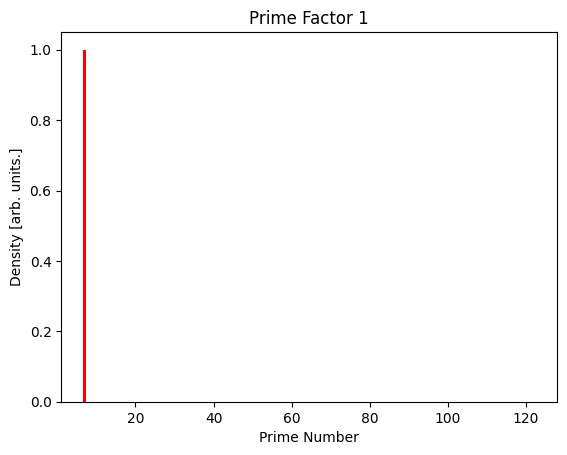

In [26]:
import numpy as np
from numpy import zeros,reshape,sqrt,arange,vectorize,extract,int

import matplotlib.pyplot as plt
import tt

import mpmath
from mpmath import mp,mpf,floor,exp,nint

def parameters():
    global dim,eps,num,rmax,nsteps,d,searchspacesize,beta,betaprime
    num=mpf(7)
    beta=30
    betaprime=0.5
    dim=1
    eps=1.0e-100
    rmax=200
    nsteps=3
    d=3
    searchspacesize=2**d
    return()

def rhoo(input):
    V=1.0+0*input
    return V

def is_prime(n):
    if n % 2 == 0 and n > 1:
        return False
    return all(n % i for i in range(3,int(sqrt(n))+1,2))

def tto(input, param=None):
    global num,beta
    nevals,dim=input.shape
    out=np.zeros((nevals,))
    for ii in range(nevals):
        a=num-nint(input[ii,0])*floor(num/nint(input[ii,0]))
        out[ii]=input[ii,1]*exp(-beta*a)
    return(out)

def newtto(input, param=None):
    global num,betaprime
    nevals,dim=input.shape
    out=np.zeros((nevals,))
    for ii in range(nevals):
        a=input[ii,0]
        out[ii]=input[ii,1]*exp(-betaprime*a)
    return(out)

def ttround(input, param=None):
    nevals, dim=input.shape
    out=np.zeros((nevals,))
    for ii in range(nevals):
        out[ii]=np.round(input[ii,1])
    return(out)

def ttremovefactor(input, param=None):
    global largestfactor
    nevals,dim=input.shape
    out=np.zeros((nevals,))
    for ii in range(nevals):
        if input[ii,0]-0.5 < largestfactor:
            out[ii]=0.
        else:
            out[ii]=np.round(input[ii,1])
    return(out)

if __name__ == "__main__":
    global eps,num,rmax,nsteps,d,searchspacesize,largestfactor
    np.random.seed(1234)
    mp.dps = 10
    parameters()
    print(num)
    a=arange(2, 10**6)
    foo=vectorize(is_prime)
    pbools=foo(a)
    primes=extract(pbools, a)
    pp=np.zeros(searchspacesize,dtype=float)
    for j in range(searchspacesize):
        pp[j]=primes[j]
    ttpp=tt.tensor(reshape(pp,[2]*d))
    lprimes=[]
    ttrho=tt.multifuncrs2([ttpp],rhoo,eps,verb=0,rmax=rmax)
    for k in range(nsteps):
        ttrho=tt.multifuncrs([ttpp,ttrho],tto,eps,verb=0,
            rmax=rmax)
    ttrhostore=tt.multifuncrs([ttpp,ttrho],ttround,eps,verb=0,
        rmax=rmax)
    ttrho=ttrho*(1.0/(ttrho.norm())**2)
    plt.bar(pp,reshape(ttrho.full(),searchspacesize),color='red',ls='-',
        label='ttrho')
    plt.xlabel("Prime Number")
    plt.ylabel("Density [arb. units.]")
    plt.title("Optimized Density")
    plt.xlim(1,128)
    plt.pause(1.0)
    plt.show()

    largestfactor=0.
    count=0
    while num > 1:
        count=count+1
        ttrho=tt.multifuncrs([ttpp,ttrhostore],ttremovefactor,eps,verb=0,
            rmax=rmax)
        for k in range(nsteps):
            ttrho=tt.multifuncrs([ttpp,ttrho],newtto,eps,verb=0,
              rmax=rmax)
        ttrho=ttrho*(1.0/ttrho.norm())
        ev=nint(tt.dot(ttpp,ttrho))
        largestfactor=ev
        lprimes.append(ev)
        num=num/ev
        while nint(num)%nint(ev) == 0:
            lprimes.append(ev)
            num=num/ev
        plt.clf()
        plt.bar(pp,reshape(ttrho.full(),searchspacesize),color='red',ls='-',
          label='Density')
        plt.xlabel("Prime Number")
        plt.ylabel("Density [arb. units.]")
        plt.title("Prime Factor %i" % count)
        print("prime factors=",lprimes,num)
        plt.xlim(1,128)
        plt.show()
        plt.pause(0.2)
